Cloning the git so we can read the files directly.

In [53]:
!git clone https://github.com/rahmamohax/Geasture-Recognition.git

fatal: destination path 'Geasture-Recognition' already exists and is not an empty directory.


Importing libaries

In [54]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D ,BatchNormalization
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.layers import Activation, Flatten, Dense, Dropout, Input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    ConfusionMatrixDisplay,
    roc_curve,
    auc
)
from sklearn.preprocessing import label_binarize


Loading the CSV file

In [55]:
CSV_URL = "https://raw.githubusercontent.com/rahmamohax/Geasture-Recognition/refs/heads/main/processed_dataset/videos_metadata.csv"

df = pd.read_csv(CSV_URL)

print(df.columns)
df.head()

Index(['split', 'video_id', 'gesture', 'label', 'file_path', 'num_frames',
       'is_augmented', 'source_video_id'],
      dtype='object')


,split,video_id,gesture,label,file_path,num_frames,is_augmented,source_video_id
0,train,WIN_20180926_18_05_07_Pro_Right_Swipe_new,Right_Swipe,1,processed_dataset\train\Right_Swipe\WIN_201809...,30,False,NaN
1,train,WIN_20180926_16_56_13_Pro_Thumbs_Up_new,Thumbs_Up,4,processed_dataset\train\Thumbs_Up\WIN_20180926...,30,False,NaN
2,train,WIN_20180907_16_03_54_Pro_Right Swipe_new,Right_Swipe,1,processed_dataset\train\Right_Swipe\WIN_201809...,30,False,NaN
3,train,WIN_20180926_17_42_43_Pro_Right_Swipe_new,Right_Swipe,1,processed_dataset\train\Right_Swipe\WIN_201809...,30,False,NaN
4,train,WIN_20180926_16_59_03_Pro_Thumbs_Down_new,Thumbs_Down,3,processed_dataset\train\Thumbs_Down\WIN_201809...,30,False,NaN


Use the splits from the CSV file.

In [56]:
train_df = df[df["split"] == "train"]
val_df   = df[df["split"] == "val"]
test_df  = df[df["split"] == "test"]

print("Train:", len(train_df))
print("Val:", len(val_df))
print("Test:", len(test_df))

Train: 560
Val: 115
Test: 115


In [57]:
BASE_PATH = "/content/Geasture-Recognition"
IMG_SIZE = 224

def load_sample(relative_path):
    # Convert Windows paths → Linux
    relative_path = relative_path.replace("\\", "/")

    full_path = os.path.join(BASE_PATH, relative_path)

    x = np.load(full_path).astype(np.float32)

    if x.max() > 1.0:
        x /= 255.0

    if x.shape != (IMG_SIZE, IMG_SIZE, 3):
        x = np.resize(x, (IMG_SIZE, IMG_SIZE, 3))

    return x


Loading the Train, Val and test data using the loader.

In [58]:
X_train, y_train = [], []

for _, row in train_df.iterrows():
    X_train.append(load_sample(row["file_path"]))
    y_train.append(row["label"])


In [59]:
X_val, y_val = [], []

for _, row in val_df.iterrows():
    X_val.append(load_sample(row["file_path"]))
    y_val.append(row["label"])


In [60]:
X_test, y_test = [], []

for _, row in test_df.iterrows():
    X_test.append(load_sample(row["file_path"]))
    y_test.append(row["label"])


Converting the data to Numpy arrays.

In [61]:
X_train = np.array(X_train)
X_val   = np.array(X_val)
X_test  = np.array(X_test)

y_train = np.array(y_train)
y_val   = np.array(y_val)
y_test  = np.array(y_test)

num_classes = len(np.unique(y_train))

print("Train:", X_train.shape)
print("Val:", X_val.shape)
print("Test:", X_test.shape)
print("Classes:", num_classes)


Train: (560, 224, 224, 3)
Val: (115, 224, 224, 3)
Test: (115, 224, 224, 3)
Classes: 5


Encoding the labels

In [62]:
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_val   = tf.keras.utils.to_categorical(y_val, num_classes)
y_test  = tf.keras.utils.to_categorical(y_test, num_classes)


VGG19 Model from scratch

In [63]:

def build_vgg19_bn(input_shape=(224, 224, 3), num_classes=5):
    model = Sequential()

    # --- Input Layer ---
    model.add(Input(shape=input_shape))

    # --- Block 1 (2 Conv layers) ---
    model.add(Conv2D(64, (3, 3), padding='same', use_bias=False))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(Conv2D(64, (3, 3), padding='same', use_bias=False))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # --- Block 2 (2 Conv layers) ---
    model.add(Conv2D(128, (3, 3), padding='same', use_bias=False))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(Conv2D(128, (3, 3), padding='same', use_bias=False))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # --- Block 3 (4 Conv layers) ---
    model.add(Conv2D(256, (3, 3), padding='same', use_bias=False))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(Conv2D(256, (3, 3), padding='same', use_bias=False))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(Conv2D(256, (3, 3), padding='same', use_bias=False))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(Conv2D(256, (3, 3), padding='same', use_bias=False))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # --- Block 4 (4 Conv layers) ---
    model.add(Conv2D(512, (3, 3), padding='same', use_bias=False))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(Conv2D(512, (3, 3), padding='same', use_bias=False))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(Conv2D(512, (3, 3), padding='same', use_bias=False))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(Conv2D(512, (3, 3), padding='same', use_bias=False))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # --- Block 5 (4 Conv layers) ---
    model.add(Conv2D(512, (3, 3), padding='same', use_bias=False))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(Conv2D(512, (3, 3), padding='same', use_bias=False))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(Conv2D(512, (3, 3), padding='same', use_bias=False))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(Conv2D(512, (3, 3), padding='same', use_bias=False))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # --- Classification Head ---
    model.add(Flatten())

    # Dense Layer 1
    model.add(Dense(4096, use_bias=False))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    # Dense Layer 2
    model.add(Dense(4096, use_bias=False))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    # Output Layer
    model.add(Dense(num_classes, activation='softmax'))

    return model

# Create and compile the model
model = build_vgg19_bn(num_classes=5)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_48 (Conv2D)              │ (None, 224, 224, 64)   │         1,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_36          │ (None, 224, 224, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_36 (Activation)      │ (None, 224, 224, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_49 (Conv2D)              │ (None, 224, 224, 64)   │        36,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_37          │ (None, 224, 224, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_37 (Activation)      │ (None, 224, 224, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_50 (Conv2D)              │ (None, 112, 112, 128)  │        73,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_38          │ (None, 112, 112, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_38 (Activation)      │ (None, 112, 112, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_51 (Conv2D)              │ (None, 112, 112, 128)  │       147,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_39          │ (None, 112, 112, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_39 (Activation)      │ (None, 112, 112, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_52 (Conv2D)              │ (None, 56, 56, 256)    │       294,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_40          │ (None, 56, 56, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_40 (Activation)      │ (None, 56, 56, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_53 (Conv2D)              │ (None, 56, 56, 256)    │       589,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_41          │ (None, 56, 56, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_41 (Activation)      │ (None, 56, 56, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_54 (Conv2D)              │ (None, 56, 56, 256)    │       589,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_42          │ (None, 56, 56, 256)    │         1,02

 Total params: 139,631,813 (532.65 MB)

 Trainable params: 139,604,421 (532.55 MB)

 Non-trainable params: 27,392 (107.00 KB)

Call backs

In [64]:
checkpoint = ModelCheckpoint(
    "vgg19_best_model.h5",
    monitor="val_accuracy",
    save_best_only=True,
    verbose=1
)

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)


Training the model

In [65]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=16,
    callbacks=[checkpoint, early_stop]
)


Epoch 1/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step - accuracy: 0.2985 - loss: 1.9348
Epoch 1: val_accuracy improved from -inf to 0.18261, saving model to vgg19_best_model.h5


35/35 ━━━━━━━━━━━━━━━━━━━━ 46s 907ms/step - accuracy: 0.2994 - loss: 1.9340 - val_accuracy: 0.1826 - val_loss: 2.5256
Epoch 2/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step - accuracy: 0.4675 - loss: 1.3549
Epoch 2: val_accuracy improved from 0.18261 to 0.20870, saving model to vgg19_best_model.h5


35/35 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.4676 - loss: 1.3556 - val_accuracy: 0.2087 - val_loss: 3.3517
Epoch 3/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step - accuracy: 0.5573 - loss: 1.2287
Epoch 3: val_accuracy did not improve from 0.20870
35/35 ━━━━━━━━━━━━━━━━━━━━ 13s 381ms/step - accuracy: 0.5566 - loss: 1.2306 - val_accuracy: 0.2087 - val_loss: 4.3259
Epoch 4/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step - accuracy: 0.6278 - loss: 1.1183
Epoch 4: val_accuracy did not improve from 0.20870
35/35 ━━━━━━━━━━━━━━━━━━━━ 14s 393ms/step - accuracy: 0.6273 - loss: 1.1206 - val_accuracy: 0.1826 - val_loss: 5.7679
Epoch 5/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step - accuracy: 0.5573 - loss: 1.2383
Epoch 5: val_accuracy did not improve from 0.20870
35/35 ━━━━━━━━━━━━━━━━━━━━ 13s 383ms/step - accuracy: 0.5581 - loss: 1.2368 - val_accuracy: 0.2087 - val_loss: 5.8090
Epoch 6/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step - accuracy: 0.7014 - loss: 0.8582
Epoch 6: val_accuracy did not impr

Accuracy plot

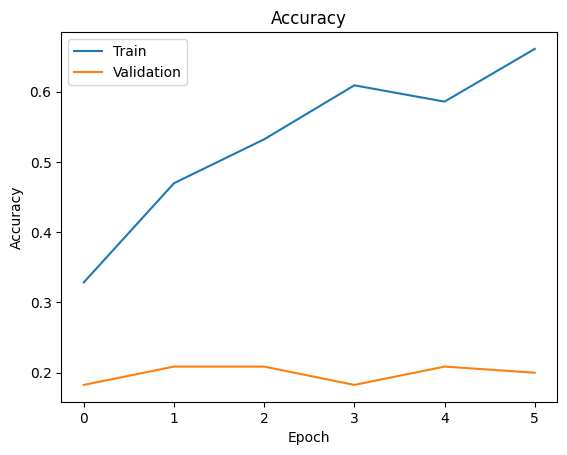

In [66]:
plt.figure()
plt.plot(history.history["accuracy"], label="Train")
plt.plot(history.history["val_accuracy"], label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy")
plt.show()


Loss plot

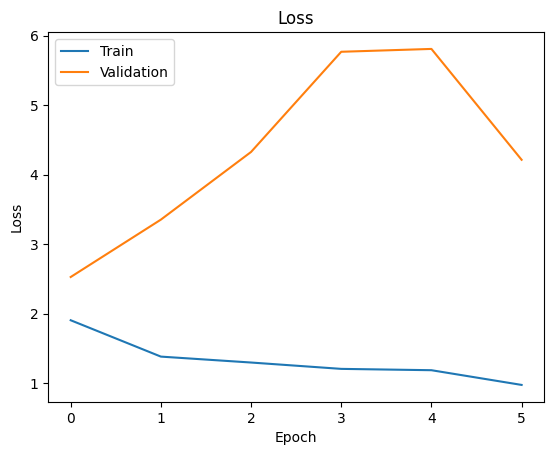

In [67]:
plt.figure()
plt.plot(history.history["loss"], label="Train")
plt.plot(history.history["val_loss"], label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss")
plt.show()


Evaluation

In [68]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test accuracy:", test_acc)


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 437ms/step - accuracy: 0.1762 - loss: 2.5513
Test accuracy: 0.1826086938381195


In [69]:

y_prob = model.predict(X_test)

y_pred = np.argmax(y_prob, axis=1)
y_true = np.argmax(y_test, axis=1)


3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 508ms/step


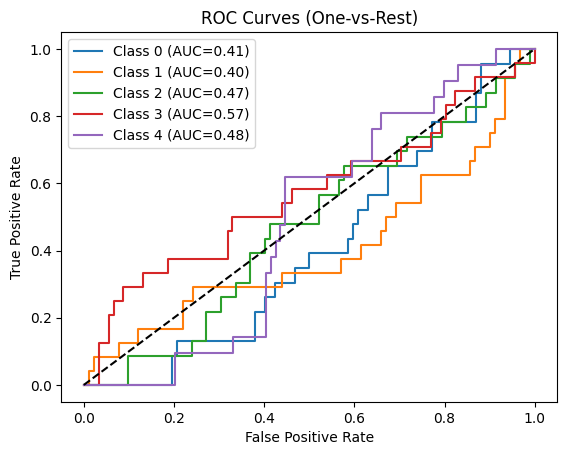

In [70]:
y_test_bin = label_binarize(y_test, classes=range(num_classes))

plt.figure()

for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {i} (AUC={roc_auc:.2f})")

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (One-vs-Rest)")
plt.legend()
plt.show()


In [71]:
auc_scores = []

for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
    auc_scores.append(auc(fpr, tpr))

print("Macro-average AUC:", np.mean(auc_scores))


Macro-average AUC: 0.466527954141074


In [72]:
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)


Confusion Matrix:
 [[ 0  0  0  0 23]
 [ 0  0  0  0 24]
 [ 0  0  0  0 23]
 [ 0  0  0  0 24]
 [ 0  0  0  0 21]]


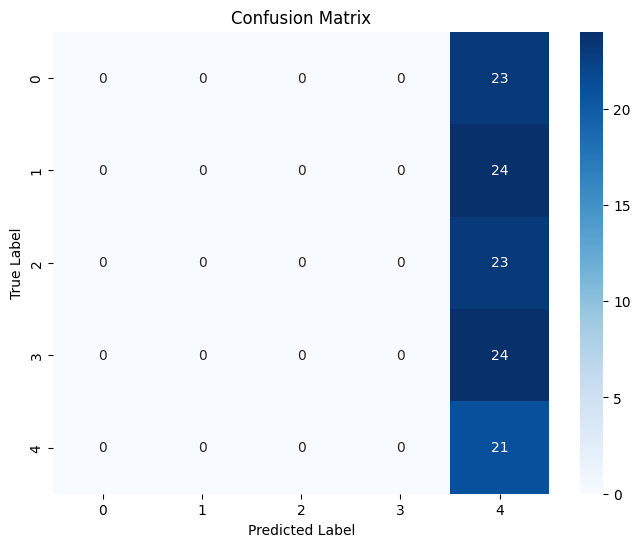

In [73]:
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=range(cm.shape[1]),
    yticklabels=range(cm.shape[0])
)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
print("Classification Report:\n")
print(classification_report(
    y_true,
    y_pred,
    digits=4
))

Classification Report:

              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000        23
           1     0.0000    0.0000    0.0000        24
           2     0.0000    0.0000    0.0000        23
           3     0.0000    0.0000    0.0000        24
           4     0.1826    1.0000    0.3088        21

    accuracy                         0.1826       115
   macro avg     0.0365    0.2000    0.0618       115
weighted avg     0.0333    0.1826    0.0564       115



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
